In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from matplotlib import pyplot as plt
from IPython import display
from collections import namedtuple
import numpy as np
from itertools import count
import math
from tqdm import trange
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Standard Q learning with additional, heuristic loss

Based on earlier experiments where the simple heuristic worked well, I've decided to modify Q learning using both temporal difference and a heuristic loss.

In [0]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayBuffer(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        rs = random.sample(self.memory, batch_size)
        return Transition(
            *(torch.cat(x).to(device) for x in zip(*rs))
        )
        #return Transition(*map(torch.cat, zip(*rs)))

    def __len__(self):
        return len(self.memory)

### Neural net for estimating Q function

Relus as activations are good because Q value in this case is [0, 200] - at least

In [0]:
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super().__init__()
        self.dense_1 = nn.Linear(input_dim, 6)
        self.dense_2 = nn.Linear(6, action_dim)
        
    def forward(self, x):
        x = F.rrelu(self.dense_1(x))
        x = F.rrelu(self.dense_2(x))
        return x

### Env

In [0]:
env = gym.make('CartPole-v0')

In [5]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [0]:
BATCH_SIZE = 256
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.0
EPS_DECAY = 300
TARGET_UPDATE = 10
AUX_REWARD_SCALE = 0  # to be compared for 0 - 200 TD reward

policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

opt = optim.Adam(policy_net.parameters(), lr=.01)
replay_buffer = ReplayBuffer(100000)

In [0]:
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():  # opt only steps over target net
            return policy_net(state[0]).max(0)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(env.action_space.n)]], device=device, dtype=torch.long)

episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    #display.clear_output(wait=True)
    #display.display(plt.gcf())

def aux_reward(state):
    free_position = 2.4 - torch.abs(state[:, 0])
    free_angle = 0.21 - torch.abs(state[:, 3])
    return free_position * free_angle * 2  # so that it takes values in [0,1] rougly

In [0]:
def optimize_model():
    if len(replay_buffer) < BATCH_SIZE:
        return
    batch = replay_buffer.sample(BATCH_SIZE)

    non_final_next_state_mask = (~torch.isnan(batch.next_state).max(1)[0]).to(torch.bool)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(batch.state).gather(1, batch.action)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    next_state_values[non_final_next_state_mask] = target_net(batch.next_state[non_final_next_state_mask]).max(1)[0].detach()  # max(1) here is precisely greedy
    
    # Compute the expected Q values - TD part
    expected_state_action_values = ((next_state_values * GAMMA) + batch.reward)
    # Add the heuristic reward
    heuristic_reward = torch.zeros(BATCH_SIZE, device=device)
    heuristic_reward[non_final_next_state_mask] = aux_reward(batch.next_state[non_final_next_state_mask])
    expected_state_action_values += heuristic_reward * AUX_REWARD_SCALE

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    opt.zero_grad()
    loss.backward()
    
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    opt.step()

In [0]:
# aux_reward(batch.next_state[non_final_next_state_mask])


In [0]:
def state_fix(state):
    return torch.from_numpy(state).unsqueeze(0).to(device=device, dtype=torch.float)

In [10]:
target_net.float()
policy_net.float()

DQN(
  (dense_1): Linear(in_features=4, out_features=6, bias=True)
  (dense_2): Linear(in_features=6, out_features=2, bias=True)
)

In [0]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

def evaluate(num_episodes=300):
    target_net.apply(weight_reset)
    policy_net.apply(weight_reset)
    episode_durations = []
    global steps_done
    steps_done = 0
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        state = state_fix(env.reset())
        for t in count():
            # env.render()
            # Select and perform an action
            action = select_action(state)
            next_state, reward, done, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            if not done:
                next_state = state_fix(next_state)
            else:
                next_state = torch.tensor(np.NaN).repeat(state.shape)

            # Store the transition in memory
            replay_buffer.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the target network)
            optimize_model()
            if done:
                episode_durations.append(t + 1)
                break
        # Update the target network, copying all weights and biases in DQN
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

    return episode_durations

### Experiments using ADAM

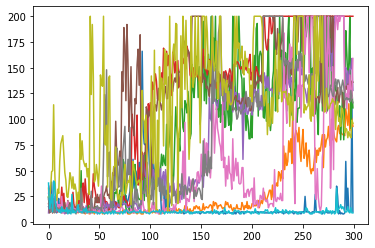

In [12]:
AUX_REWARD_SCALE = 0
for i in range(10):
  durations = evaluate()
  plt.plot(durations)
plt.show()

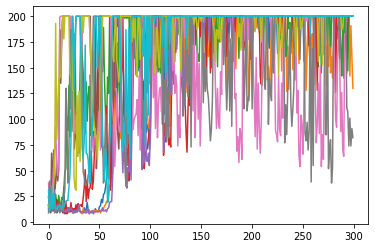

In [15]:
AUX_REWARD_SCALE = 50
for i in range(10):
  durations = evaluate()
  plt.plot(durations)
plt.show()

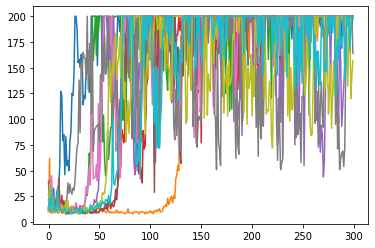

In [13]:
AUX_REWARD_SCALE = 100
for i in range(10):
  durations = evaluate()
  plt.plot(durations)
plt.show()

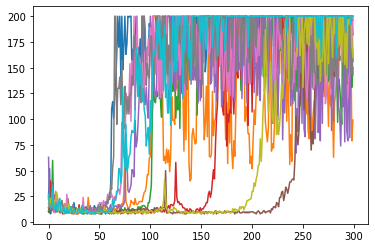

In [14]:
AUX_REWARD_SCALE = 200
for i in range(10):
  durations = evaluate()
  plt.plot(durations)
plt.show()

### Experiments using RMSprop

I haven't done lr search for RMSprop, but defaults for it and Adam are the same, so it should be representative.

In [0]:
opt = optim.RMSprop(policy_net.parameters(), .01)

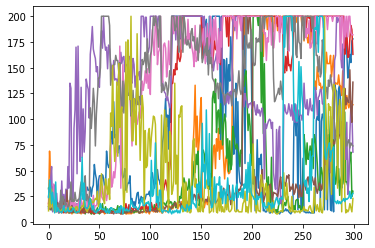

In [23]:
AUX_REWARD_SCALE = 0
for i in range(10):
  durations = evaluate()
  plt.plot(durations)
plt.show()

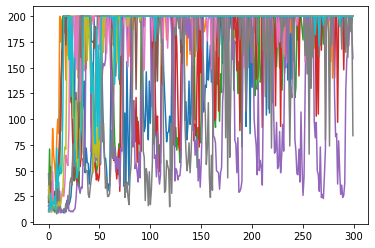

In [25]:
AUX_REWARD_SCALE = 50
for i in range(10):
  durations = evaluate()
  plt.plot(durations)
plt.show()

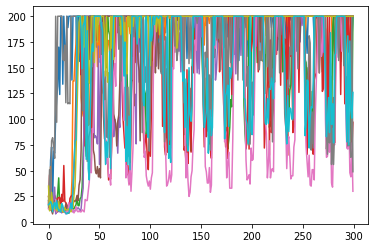

In [24]:
AUX_REWARD_SCALE = 100
for i in range(10):
  durations = evaluate()
  plt.plot(durations)
plt.show()